# Numerical Solvers for ODEs

@[Chaoming Wang](mailto:chao.brain@qq.com)

Brain modeling toolkit provided in BrainPy is focused on **differential equations**. How to solve differential equations is the essence of the neurodynamics simulation. The exact algebraic solutions are only available for low-order differential equations. For the coupled high-dimensional non-linear brain dynamical systems, we need to resort to using numerical methods for solving such differential equations. 

In this section, I will illustrate how to define ordinary differential quations (ODEs), and how to define the numerical integration methods for them in BrainPy.

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.__version__

'1.1.0'

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

## How to define ODE functions?

BrainPy provides a convenient and intuitive way to define ODE systems. For the ODE

$$
{dx \over dt} = f_1(x, t, y, p_1)\\
{dy \over dt} = f_2(y, t, x, p_2)
$$

we can define this system as a Python function: 

In [3]:
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

where `t` denotes the current time, `p1` and `p2` which after the `t` are represented as parameters needed in this system, and `x` and `y` passed before `t` denotes the dynamical variables. In the function body, the derivative for each variable can be customized by the user's need `f1` and `f2`. Finally, we return the corresponding derivatives `dx` and `dy` with the order the same as the variables in the function arguments.

For each variable `x` or `y`, it can be a scalar (`var_type = bp.integrators.SCALAR_VAR`), a vector/matrix (`var_type = bp.integrators.POP_VAR`), or a system (`var_type = bp.integrators.SYSTEM_VAR`). Here, the "system" means that the argument `x` denotes an array of variables. Take the above example as the demonstration again, we can redefine it as:

In [4]:
def diff(xy, t, p1, p2):
    x, y = xy
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return bm.array([dx, dy])

## How to define the numerical integration for ODEs?

After the definition of ODE functions, the numerical integration of these functions are very easy in BrainPy. We just need put a decorator (`bp.odeint`). 

In [5]:
@bp.odeint
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

After wrapping the derivative function by ``bp.odeint``, the function becomes an instance of ``ODEintegrator``.

In [6]:
isinstance(diff, bp.ode.ODEIntegrator)

True

`bp.odeint` receives several arguments:

1. **"method"**: A string, used to specify the numerical methods to integrate the ODE functions. The default method is [Euler](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst).

In [7]:
diff

2. **"dt"**: A float, used to set the default numerical precision. The default "dt" is 0.1. 

In [8]:
diff.dt

0.1

3. **"show_code"**: bool, indicates whether show the numerical integration code. Let's take [Euler method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst) and [RK4 method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.RK4.rst) as the illustrated examples.

In [9]:
@bp.odeint(method='euler', show_code=True, dt=0.01)
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

diff

def brainpy_itg_of_ode1_diff(x, y, t, p1, p2, dt=0.01):
  dx_k1, dy_k1 = f(x, y, t, p1, p2)
  x_new = x + dx_k1 * dt * 1
  y_new = y + dy_k1 * dt * 1
  return x_new, y_new

{'f': <function diff at 0x7fa928517e50>}



In [10]:
@bp.odeint(method='rk4', show_code=True, dt=0.1)
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

diff

def brainpy_itg_of_ode2_diff(x, y, t, p1, p2, dt=0.1):
  dx_k1, dy_k1 = f(x, y, t, p1, p2)
  k2_x_arg = x + dt * dx_k1 * 0.5
  k2_y_arg = y + dt * dy_k1 * 0.5
  k2_t_arg = t + dt * 0.5
  dx_k2, dy_k2 = f(k2_x_arg, k2_y_arg, k2_t_arg, p1, p2)
  k3_x_arg = x + dt * dx_k2 * 0.5
  k3_y_arg = y + dt * dy_k2 * 0.5
  k3_t_arg = t + dt * 0.5
  dx_k3, dy_k3 = f(k3_x_arg, k3_y_arg, k3_t_arg, p1, p2)
  k4_x_arg = x + dt * dx_k3
  k4_y_arg = y + dt * dy_k3
  k4_t_arg = t + dt
  dx_k4, dy_k4 = f(k4_x_arg, k4_y_arg, k4_t_arg, p1, p2)
  x_new = x + dx_k1 * dt * 1/6 + dx_k2 * dt * 1/3 + dx_k3 * dt * 1/3 + dx_k4 * dt * 1/6
  y_new = y + dy_k1 * dt * 1/6 + dy_k2 * dt * 1/3 + dy_k3 * dt * 1/3 + dy_k4 * dt * 1/6
  return x_new, y_new

{'f': <function diff at 0x7fa928517a60>}



## Two Illustrated Examples

### Example 1: FitzHugh–Nagumo model

Now, let's take the well known [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model) as an exmaple to illustrate how to define ODE solvers for brain modeling. The FitzHugh–Nagumo model (FHN) model has two dynamical variables, which are governed by the following equations:

$$
\begin{split}
\tau {\dot  {w}}&=v+a-bw\\
{\dot {v}} &=v-{\frac {v^{3}}{3}}-w+I_{\rm {ext}}
\end{split}
$$

For this FHN model, we can code it in BrainPy like this:

In [11]:
@bp.odeint(dt=0.01)
def integral(V, w, t, Iext, a, b, tau):
    dw = (V + a - b * w) / tau
    dV = V - V * V * V / 3 - w + Iext
    return dV, dw

After defining the numerical solver, the solution of the ODE system in the given times can be easily solved. For example, for the given parameters,

In [12]:
a=0.7;   b=0.8;   tau=12.5;   Iext=1.

the solution of the FHN model between 0 and 100 ms can be approximated by 

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

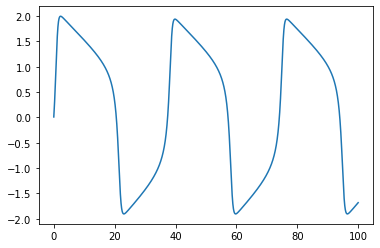

In [14]:
hist_times = bm.arange(0, 100, 0.01)
hist_V = []
V, w = 0., 0.
for t in hist_times:
    V, w = integral(V, w, t, Iext, a, b, tau)
    hist_V.append(V)

plt.plot(hist_times, hist_V)

### Example 2: Hodgkin–Huxley model

Another more complex example is the classical [Hodgkin–Huxley neuron model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model). In HH model, four dynamical variables (`V, m, n, h`) are used for modeling the initiation and propagration of the action potential. Specificaly, they are governed by the following equations:

$$
\begin{aligned}
C_{m} \frac{d V}{d t} &=-\bar{g}_{\mathrm{K}} n^{4}\left(V-V_{K}\right)- \bar{g}_{\mathrm{Na}} m^{3} h\left(V-V_{N a}\right)-\bar{g}_{l}\left(V-V_{l}\right)+I_{s y n} \\
\frac{d m}{d t} &=\alpha_{m}(V)(1-m)-\beta_{m}(V) m \\
\frac{d h}{d t} &=\alpha_{h}(V)(1-h)-\beta_{h}(V) h \\
\frac{d n}{d t} &=\alpha_{n}(V)(1-n)-\beta_{n}(V) n
\end{aligned}
$$

In BrainPy, such dynamical system can be coded as:

In [15]:
@bp.odeint(method='rk4', dt=0.01)
def integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

Same as the FHN model, we can also integrate the HH model in the given parameters and time interval:

In [16]:
Iext=10.;   ENa=50.;   EK=-77.;   EL=-54.387
C=1.0;      gNa=120.;  gK=36.;    gL=0.03

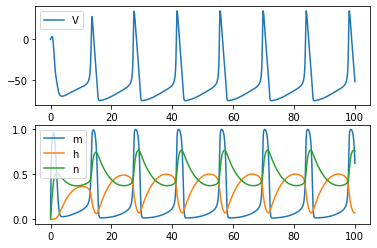

In [17]:
hist_times = bm.arange(0, 100, 0.01)
hist_V, hist_m, hist_h, hist_n = [], [], [], []
V, m, h, n = 0., 0., 0., 0.
for t in hist_times:
    V, m, h, n = integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C)
    hist_V.append(V)
    hist_m.append(m)
    hist_h.append(h)
    hist_n.append(n)

plt.subplot(211)
plt.plot(hist_times, hist_V, label='V')
plt.legend()
plt.subplot(212)
plt.plot(hist_times, hist_m, label='m')
plt.plot(hist_times, hist_h, label='h')
plt.plot(hist_times, hist_n, label='n')
plt.legend()
plt.show()

## Provided ODE Numerical Solvers

`BrainPy` provides several numerical methods for ordinary differential equations (ODEs). Specifically, we provide explicit Runge-Kutta methods, adaptive Runge-Kutta methods, and Exponential Euler method for ODE numerical integration.

### Explicit Runge-Kutta methods for ODEs

The first category of ODE numerical integration support is the [explicit Runge-Kutta (RK) methods](../apis/integrators/ode_explicit_rk.rst). RK methods are a huge family of numerical methods with a wide variety of trade-offs: efficiency, accuracy, stability, etc. The supported RK methods are listed in the following table:

| Methods                                                 | Keywords    |
|-----------------------------------------------------|-------------|
| [Euler](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst) | euler       |
| [Midpoint](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.MidPoint.rst) | midpoint    |
| [Heun's second-order method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Heun2.rst) | heun2       |
| [Ralston's second-order method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Ralston2.rst) | ralston2    |
| [RK2](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.RK2.rst)| rk2         |
| [RK3](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.RK3.rst) | rk3         |
| [RK4](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.RK4.rst) | rk4         |
| [Heun's third-order method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Heun3.rst) | heun3       |
| [Ralston's third-order method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Ralston3.rst) | ralston3    |
| [Third-order Strong Stability Preserving Runge-Kutta](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.SSPRK3.rst) | ssprk3      |
| [Ralston's fourth-order method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Ralston4.rst) | ralston4    |
| [Runge-Kutta 3/8-rule fourth-order method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.RK4Rule38.rst)| rk4_38rule |

Users can utilize these methods by specify the `method` option in `brainpy.odeint()` with their corresponding keyword. For example:

In [18]:
@bp.odeint(method='rk4')
def int_v(v, t, p):
    # do something
    return v

int_v

Or, you can directly instance your favorite integrator like:

In [19]:
@bp.ode.RK4
def int_v(v, t, p):
    # do something
    return v

int_v

In [20]:
def derivative(v, t, p):
    # do something
    return v

int_v = bp.ode.RK4(derivative, dt=0.01)
int_v

### Adaptive Runge-Kutta methods for ODEs

The second category of ODE numerical support is the [adaptive RK methods](../apis/integrators/ode_adaptive_rk.rst). What's different from the explicit RK methods is that adaptive methods are designed to produce an estimate of the local truncation error in a single Runge-Kutta step, then such error can be used to adaptively control the numerical step size. Specifically, if $error > tol$, then replace $dt$ with $dt_{new}$ and repeat the step. Therefore, adaptive RK methods allow the varied step size. In BrainPy, the following adaptive RK methods are provided:

| Methods                   | keywords    |
|---------------------------|-------------|
| [Runge–Kutta–Fehlberg 4(5)](../apis/integrators/generated/brainpy.integrators.ode.adaptive_rk.RKF45.rst)  | rkf45       |
| [Runge–Kutta–Fehlberg 1(2)](../apis/integrators/generated/brainpy.integrators.ode.adaptive_rk.RKF12.rst) | rkf12       |
| [Dormand–Prince method](../apis/integrators/generated/brainpy.integrators.ode.adaptive_rk.DormandPrince.rst) | rkdp        |
| [Cash–Karp method](../apis/integrators/generated/brainpy.integrators.ode.adaptive_rk.CashKarp.rst) | ck          |
| [Bogacki–Shampine method](../apis/integrators/generated/brainpy.integrators.ode.adaptive_rk.BogackiShampine.rst) | bs          |
| [Heun–Euler method](../apis/integrators/generated/brainpy.integrators.ode.adaptive_rk.HeunEuler.rst)  | heun_euler |

In default, the above methods are not adaptive, unless users provide a keyword `adaptive=True` in `brainpy.odeint()`. When users use the adaptive RK methods for numerical integration, the instantaneously adjusted stepsize `dt` will be appended in the functional arguments. Moreover, the tolerance `tol` for stepsize adjustment can also be controlled by users. Let's take the Lorenz system as the example:

In [21]:
# adaptively adjust stepsize

@bp.odeint(method='rkf45', 
           adaptive=True, # active the "adaptive" option
           tol=0.001) # set the tolerance
def lorenz(x, y, z, t, sigma, beta, rho):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return dx, dy, dz

In [22]:
times = bm.arange(0, 100, 0.01)
hist_x, hist_y, hist_z, hist_dt = [], [], [], []
x, y, z, dt = bm.array([1]), bm.array([1]), bm.array([1]), 0.05
for t in times:
    # should provide one more argument "dt" when using the adaptive rk method
    x, y, z, dt = lorenz(x, y, z, t, sigma=10, beta=8/3, rho=28, dt=dt)  
    hist_x.append(x)
    hist_y.append(y)
    hist_z.append(z)
    hist_dt.append(dt)
hist_x = bm.array(hist_x).flatten()
hist_y = bm.array(hist_y).flatten()
hist_z = bm.array(hist_z).flatten()
hist_dt = bm.array(hist_dt)

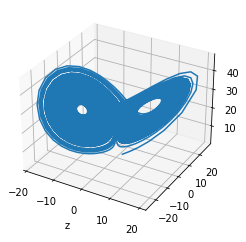

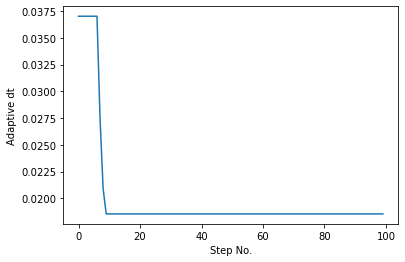

In [23]:
fig = plt.figure()
ax = plt.subplot(projection='3d')
plt.plot(hist_x, hist_y, hist_z)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')

fig = plt.figure()
plt.plot(hist_dt[:100])
plt.xlabel('Step No.')
plt.ylabel('Adaptive dt')
plt.show()

### Exponential Euler methods for ODEs

Finally, BrainPy provides [Exponential integrators](../apis/integrators/ode_exponential.rst) for ODEs. For you linear ODE systems, we highly recommend you to to use Exponential Euler methods. 

| Methods           | keywords           |
|-------------------|--------------------|
| [Exponential Euler](../apis/integrators/generated/brainpy.integrators.ode.exponential.ExponentialEuler.rst) | exponential_euler |

For a linear system, 

$$
{dy \over dt} = A - By
$$

the exponential Euler schema is given by:

$$
y(t+dt) = y(t) e^{-B*dt} + {A \over B}(1 - e^{-B*dt})
$$

As you can see, for such linear systems, the exponential Euler schema is nearly the exact solution. 

In BrainPy, in order to automatically find out the linear part, we will utilize the [SymPy](https://www.sympy.org/) to parse user defined functions. Therefore, ones need install `sympy` first when using exponential Euler method. 

What's interesting, the computational expensive neuron model --- Hodgkin–Huxley model --- is a linear-like ODE system. In the next, you will find that by using Exponential Euler method, the numerical step can be enlarged much to save the computation time. 

$$
\begin{aligned}
C_{m}{\frac {d V}{dt}}&= -\left[{\bar {g}}_{\text{K}}n^{4} + {\bar {g}}_{\text{Na}}m^{3}h + {\bar {g}}_{l} \right] V  +{\bar {g}}_{\text{K}}n^{4} V_{K} + {\bar {g}}_{\text{Na}}m^{3}h V_{Na} + {\bar {g}}_{l} V_{l} + I_{syn} \\
{\frac {dm}{dt}} &= \left[-\alpha _{m}(V)-\beta _{m}(V)\right]m + \alpha _{m}(V) \\
{\frac {dh}{dt}} &= \left[-\alpha _{h}(V)-\beta _{h}(V)\right]h + \alpha _{h}(V) \\
{\frac {dn}{dt}} &= \left[-\alpha _{n}(V)-\beta _{n}(V)\right]n + \alpha _{n}(V) \\
\end{aligned}
$$

In [24]:
Iext=10.;   ENa=50.;   EK=-77.;   EL=-54.387
C=1.0;      gNa=120.;  gK=36.;    gL=0.03

In [25]:
def derivative(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

In [26]:
def run(method, Iext=10., dt=0.1):
    hist_times = bm.arange(0, 100, dt)
    hist_V, hist_m, hist_h, hist_n = [], [], [], []
    V, m, h, n = 0., 0., 0., 0.
    for t in hist_times:
        V, m, h, n = method(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C)
        hist_V.append(V)
        hist_m.append(m)
        hist_h.append(h)
        hist_n.append(n)

    plt.subplot(211)
    plt.plot(hist_times, hist_V, label='V')
    plt.legend()
    plt.subplot(212)
    plt.plot(hist_times, hist_m, label='m')
    plt.plot(hist_times, hist_h, label='h')
    plt.plot(hist_times, hist_n, label='n')
    plt.legend()

**Euler Method**

<ipython-input-25-35d6bfdac53f>:2: RuntimeWarning: overflow encountered in exp
  alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
<ipython-input-25-35d6bfdac53f>:3: RuntimeWarning: overflow encountered in exp
  beta = 4.0 * bm.exp(-(V + 65) / 18)
<ipython-input-25-35d6bfdac53f>:6: RuntimeWarning: overflow encountered in exp
  alpha = 0.07 * bm.exp(-(V + 65) / 20.)
<ipython-input-25-35d6bfdac53f>:7: RuntimeWarning: overflow encountered in exp
  beta = 1 / (1 + bm.exp(-(V + 35) / 10))
<ipython-input-25-35d6bfdac53f>:10: RuntimeWarning: overflow encountered in exp
  alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
<ipython-input-25-35d6bfdac53f>:11: RuntimeWarning: overflow encountered in exp
  beta = 0.125 * bm.exp(-(V + 65) / 80)
<ipython-input-25-35d6bfdac53f>:4: RuntimeWarning: invalid value encountered in double_scalars
  dmdt = alpha * (1 - m) - beta * m
<ipython-input-25-35d6bfdac53f>:8: RuntimeWarning: invalid value encountered in double_scalars
  dhdt = alpha * (1 - h)

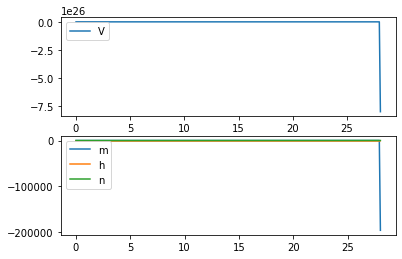

In [27]:
int1 = bp.odeint(f=derivative, method='euler', dt=0.1)

run(int1, Iext=10, dt=0.1)

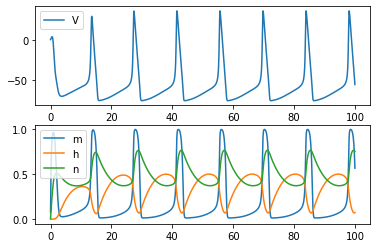

In [28]:
int2 = bp.odeint(f=derivative, method='euler', dt=0.02)

run(int2, Iext=10, dt=0.02)

**RK4 Method**

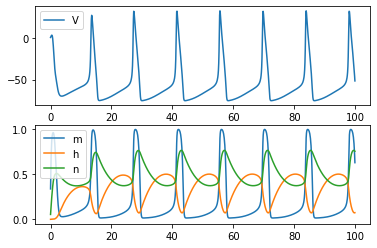

In [29]:
int3 = bp.odeint(f=derivative, method='rk4', dt=0.1)

run(int3, Iext=10, dt=0.1)

<ipython-input-25-35d6bfdac53f>:2: RuntimeWarning: overflow encountered in exp
  alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
<ipython-input-25-35d6bfdac53f>:3: RuntimeWarning: overflow encountered in exp
  beta = 4.0 * bm.exp(-(V + 65) / 18)
<ipython-input-25-35d6bfdac53f>:6: RuntimeWarning: overflow encountered in exp
  alpha = 0.07 * bm.exp(-(V + 65) / 20.)
<ipython-input-25-35d6bfdac53f>:7: RuntimeWarning: overflow encountered in exp
  beta = 1 / (1 + bm.exp(-(V + 35) / 10))
<ipython-input-25-35d6bfdac53f>:10: RuntimeWarning: overflow encountered in exp
  alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
<ipython-input-25-35d6bfdac53f>:11: RuntimeWarning: overflow encountered in exp
  beta = 0.125 * bm.exp(-(V + 65) / 80)
<ipython-input-25-35d6bfdac53f>:4: RuntimeWarning: invalid value encountered in double_scalars
  dmdt = alpha * (1 - m) - beta * m
<ipython-input-25-35d6bfdac53f>:8: RuntimeWarning: invalid value encountered in double_scalars
  dhdt = alpha * (1 - h)

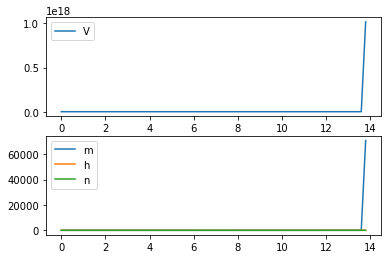

In [30]:
int4 = bp.odeint(f=derivative, method='rk4', dt=0.2)

run(int4, Iext=10, dt=0.2)

**Exponential Euler Method**

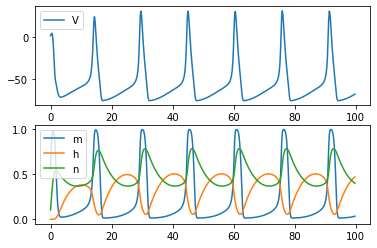

In [31]:
int5 = bp.odeint(f=derivative, method='exponential_euler', dt=0.2)

run(int5, Iext=10, dt=0.2)